# Building Predictive Machine Learning Model

#### Importing required libraries

In [1]:
import os
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

## 1. Preparing the Data

Loading the Coronary Heart Disease (CHD) dataset from the Framingham Heart Study.

In [3]:
chd_data = pd.read_csv(os.path.join('Data', 'data.csv'))
chd_data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


#### A) Removing the records that have missing/NaN values.

In [4]:
print("Size of the dataset before removing missing records = {}".format(chd_data.shape))
chd_data.dropna(inplace=True)
print("Size of the dataset after removing missing records = {}".format(chd_data.shape))

Size of the dataset before removing missing records = (4240, 16)
Size of the dataset after removing missing records = (3658, 16)


#### B) Seperating features and target labels

In [5]:
targets = chd_data.TenYearCHD
features = chd_data.drop('TenYearCHD', axis=1)

## 2. Building Logistic Regression Model

Defining the predictive model and testing it using cross-validation for robust accuracy.

### A) Declaring the Classifier

In [9]:
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lrc = RandomForestClassifier(random_state=0)

### B) Training the Linear Regression Classifier

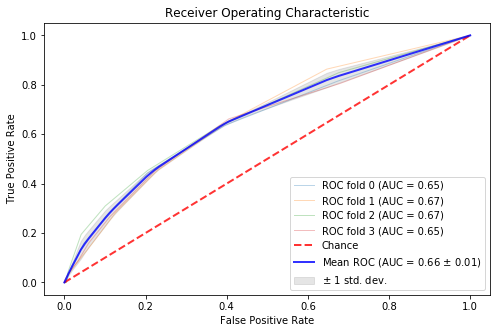

In [10]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
%matplotlib inline
plt.figure(figsize=(8, 5))

features = np.array(features)
targets = np.array(targets)

i = 0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
skf = StratifiedKFold(n_splits=4)
for train, test in skf.split(features, targets):
    probas_ = lrc.fit(features[train], targets[train]).predict_proba(features[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(targets[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('../Results/ROC_LR.png')
plt.show()

<hr>

In [13]:
chd_data["CHDProbability"] = lrc.predict_proba(features)[:,1]

In [14]:
chd_data["CHDProbability"]

0       0.1
1       0.0
2       0.0
3       1.0
4       0.1
       ... 
4233    0.2
4234    0.2
4237    0.1
4238    0.1
4239    0.0
Name: CHDProbability, Length: 3658, dtype: float64

In [8]:
dump(lrc, "../Results/model.pkl")
chd_data.to_csv("../Visualiz/data/orignal.csv", index=False)

<hr>